In [2]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
dev = qml.device("default.qubit", wires=6)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 

In [6]:
print(Hint)

  (-0.881438875180157) [X1]
+ (-0.5251471104131027) [X0]
+ (-0.22807972469080195) [X4]
+ (-0.17237604652888794) [X3]
+ (0.015358953959603516) [X2]
+ (0.4907214383305254) [X5]
+ (-0.9769492859782634) [Z5 Z2]
+ (-0.8193348693270506) [Z3 Z2]
+ (-0.5631360087393709) [Z2 Z1]
+ (-0.49564807433610203) [Z5 Z4]
+ (-0.4563911805728329) [Z3 Z0]
+ (-0.37733512313606443) [Z3 Z1]
+ (-0.08669001898716844) [Z5 Z3]
+ (0.1380739754361815) [Z5 Z1]
+ (0.28442857794386533) [Z5 Z0]
+ (0.5590347585689228) [Z4 Z0]
+ (0.6400452697551615) [Z2 Z0]
+ (0.681721389722731) [Z1 Z0]
+ (0.7325567833682536) [Z4 Z2]
+ (0.8141716928926526) [Z4 Z3]
+ (0.9573011349535445) [Z4 Z1]


In [14]:
# is_First_Iteration = 1

# prev_state = np.zeros(12) # Jason: idk what to initialize this as for now? lol

(<Figure size 1368x720 with 1 Axes>, <Axes:>)


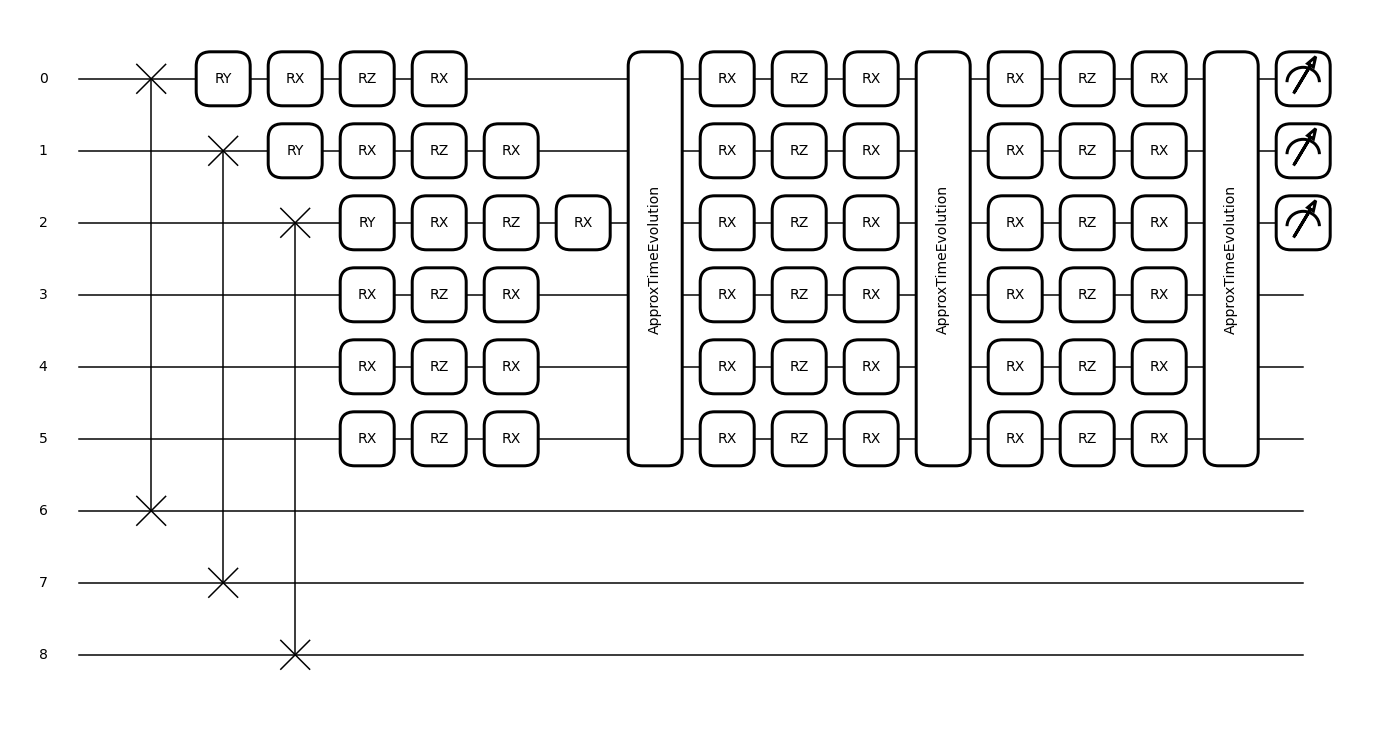

In [47]:
from pennylane.math.utils import requires_grad
# dev = qml.device("default.qubit", wires=6)
dev1 = qml.device("default.qubit", wires=9)
dev2 = qml.device("default.qubit", wires=9)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 
# some fixed values (as specified in paper)
D = 3
tau = 0.2

is_First_Iteration = np.array(1, requires_grad=False)

prev_state = np.zeros(12, requires_grad=False) # Jason: idk what to initialize this as for now? lol

# Parameters
# alpha_array = np.zeros((D, 6))
# beta_array  = np.zeros((D, 6))
# gamma_array = np.zeros((D, 6))
alpha_array = np.random.rand(D, 6)
beta_array  = np.random.rand(D, 6)
gamma_array = np.random.rand(D, 6)
c = np.asarray(1.0)

def encoding(x):
    qml.RY(np.arccos(x), wires=0)
    qml.RY(np.arccos(x), wires=1)
    qml.RY(np.arccos(x), wires=2)

def U1(alpha, beta, gamma, wire):
     qml.RX(alpha, wires=wire)
     qml.RZ(beta, wires=wire)
     qml.RX(gamma, wires=wire)

def evolution(alpha_array, beta_array, gamma_array):
    for i in range (D): # D = 3
        # U1 rotations
        for j in range(6):
            U1(alpha_array[i][j], beta_array[i][j], gamma_array[i][j], j)

        # np.exp(-1.0*j * Hint * tau) # e^(-i Hint tau)
        #change third paramter (larger is more accurate)
        qml.ApproxTimeEvolution(Hint, tau, 1)

@qml.qnode(dev1)
def pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        qml.MottonenStatePreparation(state_vector=prev_state, wires=range(6))
        print("Just did MottonenStatePreparation using: ", prev_state)

    # prev_state = np.zeros(12)
    if (is_First_Iteration == 1):
        is_First_Iteration = 0
       
    qml.SWAP(wires=[0,6])
    qml.SWAP(wires=[1,7])
    qml.SWAP(wires=[2,8])

    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    # prev_state = qml.state()
    # print("prev_state: ", prev_state)

    # will qml.state() collapse wires before qml.expval returns?

    return [qml.expval(qml.PauliZ(i)) for i in range(3)]
    # return qml.state()

@qml.qnode(dev2)
def pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        qml.MottonenStatePreparation(state_vector=prev_state, wires=range(6))
        print("Just did MottonenStatePreparation using: ", prev_state)

    # prev_state = np.zeros(12)
    if (is_First_Iteration == 1):
        is_First_Iteration = 0
       
    qml.SWAP(wires=[0,6])
    qml.SWAP(wires=[1,7])
    qml.SWAP(wires=[2,8])

    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    # prev_state = qml.state()
    # print("prev_state: ", prev_state)

    # will qml.state() collapse wires before qml.expval returns?

    # return [qml.expval(qml.PauliZ(i)) for i in range(3)], qml.state()
    return qml.state()

#def timestep_output(x, weights):
def timestep_output(x, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
# def timestep_output(x, alpha_array, beta_array, gamma_array, c):
    
    # print(qml.draw_mpl(pqc)(0.5))
    #result = pqc(x, weights[0], weights[1], weights[2])
    result = pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)
    prev_state = pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)

    # print("Output of pqc: ", result)
    # print("Type of pqc: ", result[0])
    
    # y = c * np.average(result)
    y = c * (( result[0] + result[1] + result[2] ) / 3.0)
    # print("Output of each timestep: ", y)

    return y

timestep_output(0.7, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
# timestep_output(0.7, alpha_array, beta_array, gamma_array)
print(qml.draw_mpl(pqc_expval)(0.5, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration))

# print(qml.draw_mpl(pqc)(0.5, 1))

### random code ideas, unused

# expval1 = qml.expval(qml.PauliZ(0))
# expval2 = qml.expval(qml.PauliZ(1))
# expval3 = qml.expval(qml.PauliZ(2))

# avg = (expval1 + expval2 + expval3) / 3.0

# print([expval1.eigvals(), expval2.eigvals(), expval3.eigvals()])

# return c * avg
# return expval1, expval2, expval3

In [48]:
prev_state

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=False)

In [49]:
timestep_output(0.7, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

tensor(0.15710249, requires_grad=True)

In [50]:
# what is this for again?
len(pqc_expval.qtape.trainable_params)

99

[0.5, 0.45979899497487436, 0.41959798994974873, 0.37939698492462315, 0.33919597989949746, 0.2989949748743719, 0.25879396984924624, 0.2185929648241206, 0.17839195979899497, 0.13819095477386933, 0.0979899497487437, 0.05778894472361806, 0.017587939698492483, -0.022613065326633208, -0.06281407035175879, -0.10301507537688448, -0.14321608040201006, -0.18341708542713564, -0.22361809045226133, -0.2638190954773869, -0.3040201005025126, -0.3442211055276382, -0.3844221105527639, -0.42462311557788945, -0.46482412060301503, -0.4949748743718594, -0.4547738693467336, -0.414572864321608, -0.3743718592964824, -0.33417085427135684, -0.29396984924623104, -0.25376884422110546, -0.21356783919597988, -0.1733668341708543, -0.13316582914572872, -0.09296482412060292, -0.05276381909547734, -0.012562814070351758, 0.027638190954773822, 0.06783919597989962, 0.1080402010050252, 0.14824120603015079, 0.18844221105527637, 0.22864321608040195, 0.26884422110552775, 0.3090452261306533, 0.3492462311557789, 0.3894472361809

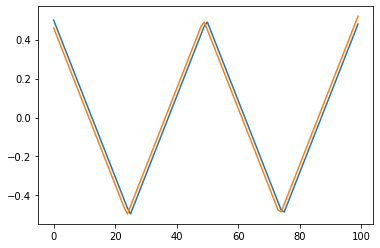

In [51]:
def generate_input(t_in):
    t = 8/199 * t_in
    if t >= 0 and t <= 1:
        return -t + 0.5
    elif t >= 1 and t <= 2:
        return t - 1.5
    elif t >= 2 and t <= 3:
        return -t + 2.5
    else:
        return t - 3.5

train_inputs = []
train_expected_outputs = []

for i in range(100):
    train_inputs.append(generate_input(i))
    train_expected_outputs.append(generate_input(i+1))

print(train_inputs)
print(train_expected_outputs)
plt.plot(train_inputs)
plt.plot(train_expected_outputs)

In [68]:
### Lecture 8 Demo helper functions

#def make_predictions(data, model, weights):
def make_predictions(data, model, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):

    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        
        preds.append(estimated_expval)
            
    return preds

def make_loss_function(data, labels, model):

    #def loss(weights):
    def loss(alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            #estimated_expval = model(point, weights)
            estimated_expval = model(point, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
            loss_sum += (estimated_expval - true_expval) ** 2

        return loss_sum / len(data)
    
    return loss

def compute_accuracy(predictions, true_labels):
    """Compute the accuracy of our predictions.
    
    Args:
        predictions (array[int]): Predicted values to 
        true_labels (array[int]): Integers identifying the class/label of 
            each data point.
    
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(predictions)
    
    return np.sum(
        [np.abs(predictions[x]-true_labels[x]) < 0.1 for x in range(n_samples)
    ]) / n_samples

In [69]:
loss = make_loss_function(train_inputs, train_expected_outputs, timestep_output)

In [70]:
gradient_function = qml.grad(timestep_output)

In [71]:
prev_state

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=False)

In [76]:
# tune this parameter!
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

# weights = [alpha_array, beta_array, gamma_array, c]
# weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()

for it in range(n_its):
    # weights, _loss = opt.step_and_cost(loss, weights)
    # Add c as a trainable parameter
    (alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration), _loss = opt.step_and_cost(loss, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

    if it % 5 == 0:
        #our_preds = make_predictions(train_inputs, timestep_output, weights)
        our_preds = make_predictions(train_inputs, timestep_output, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, train_expected_outputs)}")
    loss_track.append(_loss)

Loss at iteration 0 = 0.32006361608680867  Accuracy = 0.14
Loss at iteration 5 = 0.19437252092302618  Accuracy = 0.16
Loss at iteration 10 = 0.15290543887007912  Accuracy = 0.17
Loss at iteration 15 = 0.13318605413178605  Accuracy = 0.16
Loss at iteration 20 = 0.12152205742441584  Accuracy = 0.18
Loss at iteration 25 = 0.11364188807106883  Accuracy = 0.17
Loss at iteration 30 = 0.10785939096072834  Accuracy = 0.18
Loss at iteration 35 = 0.10338719876203062  Accuracy = 0.18
Loss at iteration 40 = 0.09980704367824683  Accuracy = 0.19
Loss at iteration 45 = 0.0968723267307651  Accuracy = 0.19
Loss at iteration 50 = 0.0944245116258568  Accuracy = 0.2
Loss at iteration 55 = 0.09235403632785885  Accuracy = 0.19
Loss at iteration 60 = 0.09058052297643143  Accuracy = 0.19
Loss at iteration 65 = 0.08904206663822123  Accuracy = 0.19
Loss at iteration 70 = 0.08768908746987644  Accuracy = 0.2
Loss at iteration 75 = 0.08648060556390398  Accuracy = 0.2
Loss at iteration 80 = 0.08538186336911269  Acc

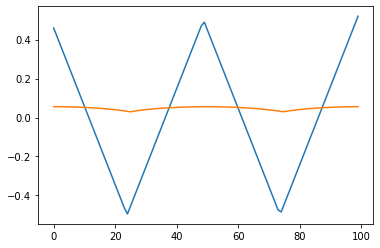

In [77]:
plt.plot(train_expected_outputs)
plt.plot(our_preds)

In [78]:
c

tensor(0.27448416, requires_grad=True)

In [79]:
# weights = np.random.normal(size=(2, 3), requires_grad=True)
weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()
weights

/usr/local/lib/python3.9/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


[array([[ 0.15634256,  0.59661294, -0.02111716,  0.57026653,  0.79708679,
          0.60062598],
        [ 0.73207787,  0.806465  ,  0.40690105,  0.62580595,  0.55368688,
          0.324668  ],
        [ 0.12706062,  0.84230785,  0.38370028,  0.22256037,  0.3916795 ,
          0.71787136]]),
 array([[0.95561752, 1.09364412, 0.35523035, 0.52312028, 0.21748917,
         0.51085132],
        [0.07948489, 0.81582086, 0.36945563, 0.33566481, 0.94546314,
         0.21337947],
        [0.20648739, 0.49657897, 0.82724668, 0.04210303, 0.7119047 ,
         0.05289276]]),
 array([[0.30971562, 0.76787862, 0.32679222, 0.97409663, 0.88088791,
         0.84241184],
        [0.31713453, 0.33924996, 0.04970091, 0.42309529, 0.68439248,
         0.37491977],
        [0.78173821, 1.20597218, 0.6240106 , 0.78181412, 0.91282262,
         0.6951284 ]]),
 array(0.27448416)]